In [1]:
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
from diffusers import DDPMPipeline, DDPMScheduler

/home/t-jiaweiwang/miniconda3/envs/minigpt4/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/home/t-jiaweiwang/miniconda3/envs/minigpt4/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues


In [2]:
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))

In [5]:
model_id = "google/ddpm-celebahq-256"  # 本地模型路径
pipeline = DDPMPipeline.from_pretrained(
    model_id,
    local_files_only=False  # 确保只使用本地文件
)

diffusion_pytorch_model.safetensors not found
Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]An error occurred while trying to fetch /home/t-jiaweiwang/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory /home/t-jiaweiwang/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...: 100%|██████████| 2/2 [00:00<00:00,  6.60it/s]


In [24]:
import os

# 初始化调度器
scheduler = DDPMScheduler.from_pretrained(model_id)

# 图像预处理函数
def preprocess(image_path, image_size=256):
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
    return transform(image).unsqueeze(0), image.size  # 增加批次维度

# 加噪函数
def add_noise(image, scheduler, steps=50):
    noisy_image = image.clone()
    for t in range(steps):
        noise = torch.randn_like(image)
        beta = scheduler.betas[t]
        noisy_image = (noisy_image * (1 - beta).sqrt() + noise * beta.sqrt())
    return noisy_image

# 逐步去噪函数
def gradual_denoise(noisy_image, pipeline, scheduler, steps=50):
    for t in reversed(range(steps)):
        with torch.no_grad():
            # 调用调度器的 step 函数逐步还原图像
            noise_pred = pipeline.unet(noisy_image, t)["sample"]
            noisy_image = scheduler.step(noise_pred, t, noisy_image)["prev_sample"]
    return noisy_image

# 显示图像函数
def show_image(tensor_image):
    image = tensor_image.squeeze(0).permute(1, 2, 0)
    image = (image * 0.5 + 0.5).clamp(0, 1)  # 反归一化
    image = (image.numpy() * 255).astype(np.uint8)
    return Image.fromarray(image)

# 主函数
def main(image_path):
    # 预处理图像
    original_image, image_size = preprocess(image_path)
    print(image_size)
    
    # 加噪图像
    noisy_image = add_noise(original_image, scheduler, steps=50)
    
    # 逐步去噪图像
    denoised_image = gradual_denoise(noisy_image, pipeline, scheduler, steps=50)

    # 恢复到原图大小
    denoised_image = transforms.Resize(image_size)(denoised_image)
    original_image = transforms.Resize(image_size)(original_image)
    noisy_image = transforms.Resize(image_size)(noisy_image)
    
    # 显示原图、加噪图和去噪图
    original_img = show_image(original_image)
    noisy_img = show_image(noisy_image)
    denoised_img = show_image(denoised_image)
    
    original_img.show(title="Original Image")
    noisy_img.show(title="Noisy Image")
    denoised_img.show(title="Denoised Image")
    os.makedirs("defense/diffusion", exist_ok=True)
    original_img.save("defense/diffusion/original.jpg")
    noisy_img.save("defense/diffusion/noisy.jpg")
    denoised_img.save("defense/diffusion/denoised.jpg")

    return original_img, noisy_img, denoised_img

In [27]:
scheduler.betas.shape

torch.Size([1000])

(224, 224)


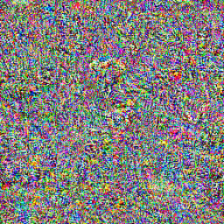

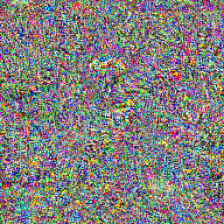

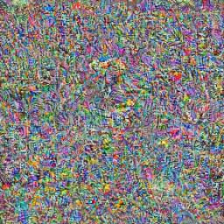

In [28]:
original_img, noisy_img, denoised_img = main("adversarial_images/prompt_unconstrained.bmp")

In [7]:
import numpy as np

np.abs(np.array(original_img)[:6] - np.array(denoised_img)[:6]).mean()

np.float64(109.31358506944444)